In [1]:
import numpy as np
from coverage import *
from datetime import datetime, timezone, timedelta
import dataclasses
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import branca
import folium

from skyfield.framelib import itrs
from landsat import Instrument, Platform, Scene

! mkdir tmp

mkdir: tmp: File exists


In [2]:
start_dt = datetime.fromisoformat(Scene.start_utc)
num_days = 2

tles = gen_sats(
    # sat_nos=[Platform.norad_id] # How to best handle multiple platforms? (TLE vs. SPG4 model too)
    # sat_nos=[39084]
    sat_nos=[39084,49260]
)

inst = camera_model(
    name=Instrument.name, 
    fl=Instrument.focal_length_mm, 
    pitch=Instrument.pitch_um*1e-3, 
    h_pix=Instrument.rows, 
    v_pix=Instrument.cols, 
)

times = gen_times(
    start_yr=start_dt.year,
    start_mo=start_dt.month, 
    start_day=start_dt.day, 
    days=num_days, 
    step_min=Instrument.img_period)

xcell_size = ycell_size = .1

Satellite(s) Loaded from TLE:

[<EarthSatellite LANDSAT 8 catalog #39084 epoch 2022-06-15 18:38:09 UTC>]

[<EarthSatellite LANDSAT 9 catalog #49260 epoch 2022-06-15 11:12:37 UTC>]

Propogation time: 
 2022-07-19 00:00:00+00:00 
to 
 2022-07-20 23:59:48+00:00

In [3]:
## Batch FOV generation over N satellites - TODO: build multiple sats into config/ main script
gdfs = []
for tle in tles:
    sat = tle[0]
    fov_df = forecast_fovs(sat, times, inst)
    xyz_dist_rates = sat.at(times).frame_xyz_and_velocity(itrs)
    fov_df['x_pos'], fov_df['y_pos'], fov_df['z_pos'] = xyz_dist_rates[0].km
    fov_df['x_vel'], fov_df['y_vel'], fov_df['z_vel'] = xyz_dist_rates[1].km_per_s
    gdfs.append(fov_df)
fov_df = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="epsg:4326")

## Filter shapes crossing anti-meridian - also in main function
## TODO: Switch to stactools solution for this
fov_df["lonspan"] = fov_df.bounds['maxx'] - fov_df.bounds['minx']
fov_df = fov_df[fov_df["lonspan"] < 20].copy()
fov_df = fov_df.drop('lonspan', axis=1)

## Create cmap for unique satellites and create color column
sat_ids = list(fov_df["id"].unique()).sort()
cmap = branca.colormap.StepColormap(['red', 'blue'], sat_ids, vmin=139084, vmax = 149260)
fov_df['color'] = fov_df['id'].apply(cmap)

## Save to geojson based on sat name
for satname in fov_df.satellite.unique():
    fov_df[fov_df.satellite==satname].to_file("./tmp/{}_fovs.geojson".format(satname.replace(" ", "_")))

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [4]:
# fov_df.time = pd.to_datetime(fov_df.time)
fov_df["frac_days"] = fov_df.datetime.dt.dayofweek + fov_df.datetime.dt.hour/24 + fov_df.datetime.dt.minute/(24*60) + fov_df.datetime.dt.second/(24*60*60)
fov_df['time_gap'] = fov_df['frac_days'] - fov_df['frac_days'].shift(1)
fov_df = fov_df.drop('datetime', axis=1)
fov_df

,satellite,id,time,geometry,x_pos,y_pos,z_pos,x_vel,y_vel,z_vel,color,frac_days,time_gap
0,LANDSAT 8,139084,2022-07-19 00:00:00 UTC,"POLYGON ((-10.74489 -65.23485, -7.09859 -64.63...",3064.326917,-519.223598,-6369.476230,5.827684,-3.696273,3.106893,#ff0000ff,1.000000,NaN
1,LANDSAT 8,139084,2022-07-19 00:00:22 UTC,"POLYGON ((-11.76697 -63.97038, -8.26544 -63.38...",3191.571165,-600.599691,-6299.406958,5.739431,-3.701159,3.262733,#ff0000ff,1.000255,0.000255
2,LANDSAT 8,139084,2022-07-19 00:00:44 UTC,"POLYGON ((-12.70956 -62.70021, -9.34225 -62.13...",3316.839558,-682.058218,-6225.928239,5.648071,-3.703766,3.416828,#ff0000ff,1.000509,0.000255
3,LANDSAT 8,139084,2022-07-19 00:01:06 UTC,"POLYGON ((-13.58304 -61.42504, -10.34018 -60.8...",3440.064368,-763.548917,-6149.079379,5.553661,-3.704082,3.569095,#ff0000ff,1.000764,0.000255
4,LANDSAT 8,139084,2022-07-19 00:01:28 UTC,"POLYGON ((-14.39607 -60.14545, -11.26870 -59.6...",3561.179098,-845.021282,-6068.901504,5.456257,-3.702098,3.719452,#ff0000ff,1.001019,0.000255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15705,LANDSAT 9,149260,2022-07-20 23:58:20 UTC,"POLYGON ((158.28108 25.04390, 156.53881 25.398...",-5951.642770,2500.566773,2909.115701,-2.176788,2.702313,-6.753170,#0000ffff,2.998843,0.000255
15706,LANDSAT 9,149260,2022-07-20 23:58:42 UTC,"POLYGON ((157.94957 23.71950, 156.22552 24.072...",-5997.823240,2559.411021,2759.766660,-2.021285,2.646835,-6.823386,#0000ffff,2.999097,0.000255
15707,LANDSAT 9,149260,2022-07-20 23:59:04 UTC,"POLYGON ((157.62335 22.39446, 155.91623 22.746...",-6040.572392,2617.013428,2608.913677,-1.864866,2.589423,-6.889886,#0000ffff,2.999352,0.000255
15708,LANDSAT 9,149260,2022-07-20 23:59:26 UTC,"POLYGON ((157.30200 21.06881, 155.61061 21.419...",-6079.871090,2673.331768,2456.638933,-1.707623,2.530107,-6.952631,#0000ffff,2.999606,0.000255


In [5]:
xyz_dist_rates[0].km#.shape

array([[-3215.96772868, -3341.08894784, -3464.1440436 , ...,
        -6040.57239164, -6079.87109036, -6115.70221632],
       [  616.98831715,   698.56100696,   780.15458349, ...,
         2617.01342808,  2673.33176774,  2728.32445457],
       [ 6271.7580957 ,  6197.52372264,  6119.91752164, ...,
         2608.91367678,  2456.63893343,  2303.02539481]])

In [6]:
# %%timeit
get_inst_fov(sat, times[0], inst)

{'c1': {'lat': 63.088882683125675, 'lon': 171.46385838173472},
 'c2': {'lat': 63.654870362239215, 'lon': 168.05410014506015},
 'c3': {'lat': 62.04926130005797, 'lon': 166.89629124350247},
 'c4': {'lat': 61.51333843738, 'lon': 170.14891081178135}}

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<BarContainer object of 58 artists>

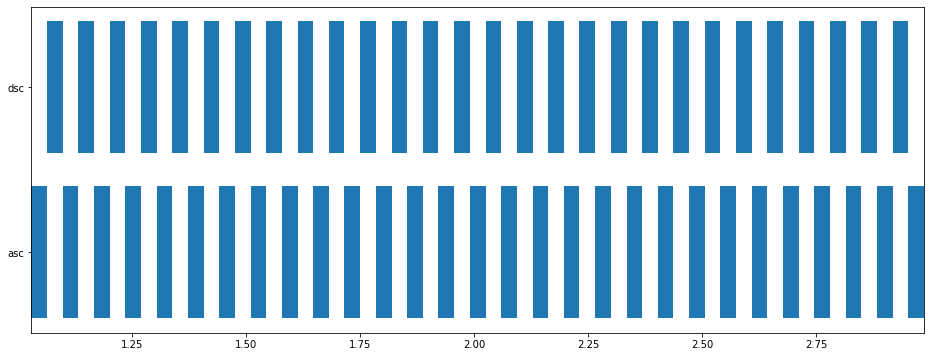

In [7]:
# fov_df.loc[fov_df.z_vel < 0]['asc_dsc'] = 'dsc'
conditions = [
    fov_df['z_vel'].lt(0),
    fov_df['z_vel'].gt(0)
]

choices = ['dsc','asc']
fov_df['asc_dsc'] = np.select(conditions, choices, default='undefined')

my_column_changes = fov_df["asc_dsc"].shift() != fov_df["asc_dsc"]
change = fov_df[my_column_changes]#[:100]
change['time_gap'] = change['frac_days'].shift(-1) - change['frac_days']

plot_df = change[change.satellite=="LANDSAT 9"][1:]
fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(plot_df['asc_dsc'], plot_df.time_gap, left=plot_df.frac_days) #, color=df.color)

In [8]:
## Drop ascending pass FOVs
fov_df.loc[fov_df.asc_dsc=="asc", "geometry"] = None

## Select AOI from gpd naturalearth dataset (filter by .name for country, .continent for continent)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != "Antarctica"]
# world = world[world.continent != "Seven seas (open ocean)"]

## Drop any FOVs not over land area
join = fov_df.sjoin(world, how="left").dropna()
fov_df.loc[join.index, 'mode'] = "SCIENCE"
fov_df.loc[~fov_df.index.isin(join.index), 'mode'] = "STANDBY"
fov_df.loc[fov_df['mode']=="STANDBY", "geometry"] = None

In [9]:
## Plotting FOVs

## Make a folium map
m = fov_df[fov_df['mode']=="SCIENCE"].explore(color="color", style_kwds={'fillOpacity':0.2}, tooltip=["satellite", "time"])

## Add WRS2
# wrs2 = gpd.read_file('./WRS2_descending_0/WRS2_descending.shp')
# wrs2 = wrs2.cx[xmin: xmax, ymin: ymax]
# folium.GeoJson(data=wrs2["geometry"], overlay=False).add_to(m)

## View or save
m#.save("./tmp/fovs_map.html")

In [10]:
## Coverage data analysis for single satellite/ batch of satellites

## Set AOI
# aoi =  world[world.name == "Brazil"].geometry
# aoi =  world[world.continent == "North America"].geometry
# aoi = world[world.name == "United States of America"].geometry # Includes Alaska...

## Or read in aoi from .geojson
aoi = gpd.read_file('./aois/eastern_us.geojson').geometry # ...so use AOI for subsection of US

## Filter fov_df by aoi
xmin, ymin, xmax, ymax= aoi.total_bounds
revisit_df = fov_df.cx[xmin: xmax, ymin: ymax]

## Create revisit map on regular grid
grid, grid_shape = calculate_revisits(revisit_df, aoi, grid_x=xcell_size, grid_y=ycell_size)
grid.to_file('./tmp/all_revisits.geojson')
grid.n_visits.fillna(0).describe()
m = revisit_map(grid, grid_shape, grid_x=xcell_size, grid_y=ycell_size)
m#.save("./tmp/revisits_map.html")

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<BarContainer object of 159 artists>

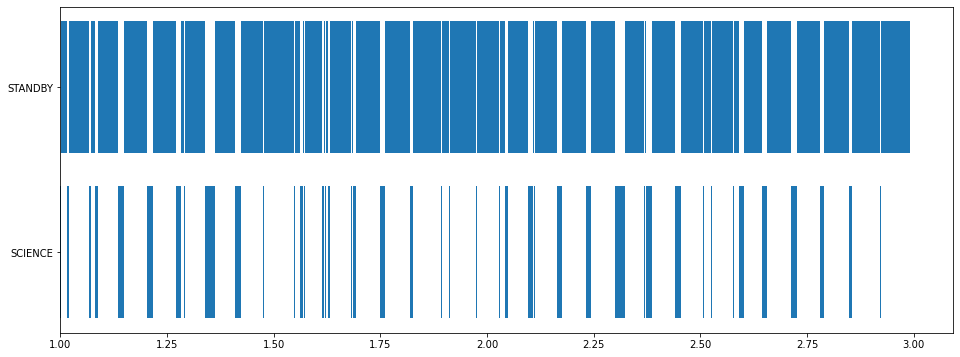

In [11]:
my_column_changes = fov_df["mode"].shift() != fov_df["mode"]

change = fov_df[my_column_changes]#[:100]

change['time_gap'] = change['frac_days'].shift(-1) - change['frac_days']
change = change[change['time_gap'] > 0]
change = change[change.satellite == "LANDSAT 9"]

fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(change['mode'], change.time_gap, left=change.frac_days) #, color=df.color)

<AxesSubplot:ylabel='Frequency'>

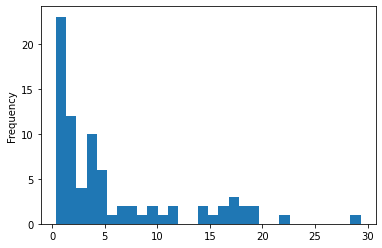

In [12]:
((change[change["mode"] == "SCIENCE"]).time_gap*24*60).plot.hist(bins=30)

In [13]:
change[change["mode"] == "SCIENCE"].time_gap.sum()/(change[change["mode"] == "STANDBY"].time_gap.sum() + change[change["mode"] == "SCIENCE"].time_gap.sum())

0.16168200408997904

In [14]:
def zero_crossing(data):
    return np.where(np.diff(np.sign(np.array(data))))[0]

def crossings_nonzero_pos2neg(data):
    pos = data > 0
    return (pos[:-1] & ~pos[1:]).nonzero()[0]

single_sat = fov_df[fov_df.satellite=="LANDSAT 8"][1:-1].reset_index(drop=True)

data = single_sat['z_pos'].values
crossings = crossings_nonzero_pos2neg(data)
single_sat.loc[crossings]
single_sat['orbit'] = 1

for crossing in crossings:
    single_sat.loc[crossing:, 'orbit'] += 1

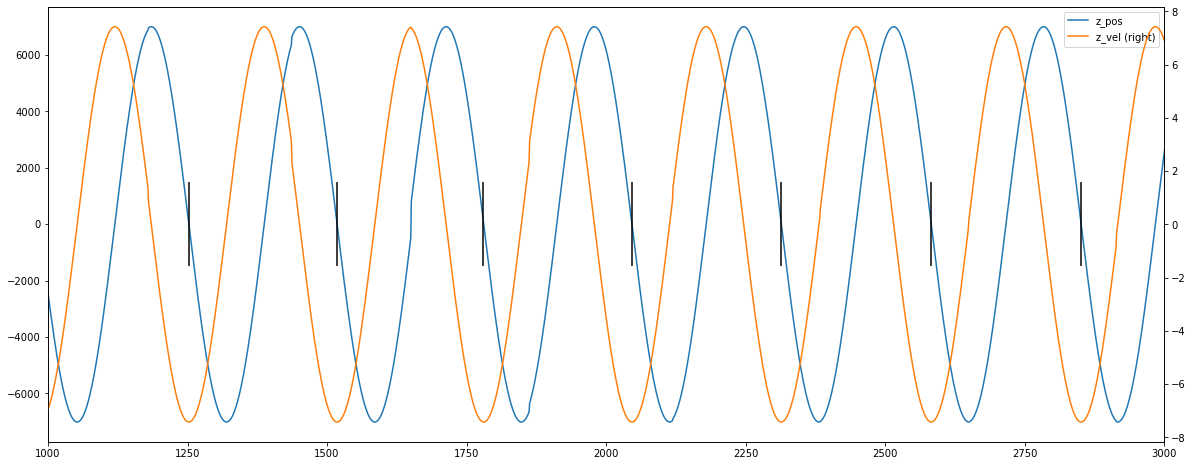

In [15]:
ax = single_sat.plot.line(y=['z_pos', 'z_vel'], xlim=[1000,3000], figsize=(20,8), subplots=False, secondary_y=['z_vel'])
ax.vlines(single_sat.loc[crossings].index, ymin=-1500, ymax=1500, color=['black'])

<AxesSubplot:ylabel='Frequency'>

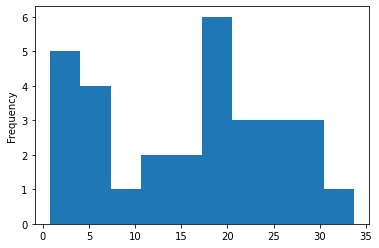

In [16]:
(single_sat[single_sat["mode"] == "SCIENCE"].groupby('orbit').time_gap.sum()*24*60).plot.hist(bins=10)

In [17]:
(single_sat[single_sat["mode"] == "SCIENCE"].groupby('orbit').time_gap.sum()*24*60).mean()

15.192222222222332